In [1]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import ticker
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from utils import create_expdf, fetch_subdf
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.utils import rl2_error

from src.model import MLP
from src.dataset import load_mat2d 
from src.utils import rl2_error

In [2]:
task = 'darcyrect'
seed = 1
gn_darcyrect_kernel = np.load('../results/{:}/GN2D-rational-65x65-50-0.2000-none-{:}/approx_kernel.npy'.format(task, seed))
gnaug2_darcyrect_kernel = np.load('../results/{:}/GN2D-rational-65x65-50-0.2000-aug2-{:}/approx_kernel.npy'.format(task, seed))

nh = 65
h = 2/(nh-1) # x in [-1, 1]
xh = torch.linspace(0,1,nh)
xhh = torch.cartesian_prod(xh, xh)

G_gn = gn_darcyrect_kernel
G_gnaug = gnaug2_darcyrect_kernel

ntest = 100
F_test = load_mat2d('../dataset/frect_65x65_2.00e-01.mat', 'F', ntest, False).T
U_test = load_mat2d('../dataset/{:}_65x65_2.00e-01.mat'.format(task), 'U', ntest, False).T

U_gnaug = h**2 * G_gnaug.reshape(nh**2,nh**2) @ F_test
U_gn = h**2 * G_gn.reshape(nh**2,nh**2) @ F_test

err_diff = []
for i in range(ntest):
    err_gnaug = rl2_error(U_gnaug[:,i], U_test[:,i])
    err_gn = rl2_error(U_gn[:,i], U_test[:,i])
    err_diff.append(err_gnaug - err_gn)
print(np.argmin(err_diff), "{:.4e}".format(min(err_diff)))

35 -4.7563e-03


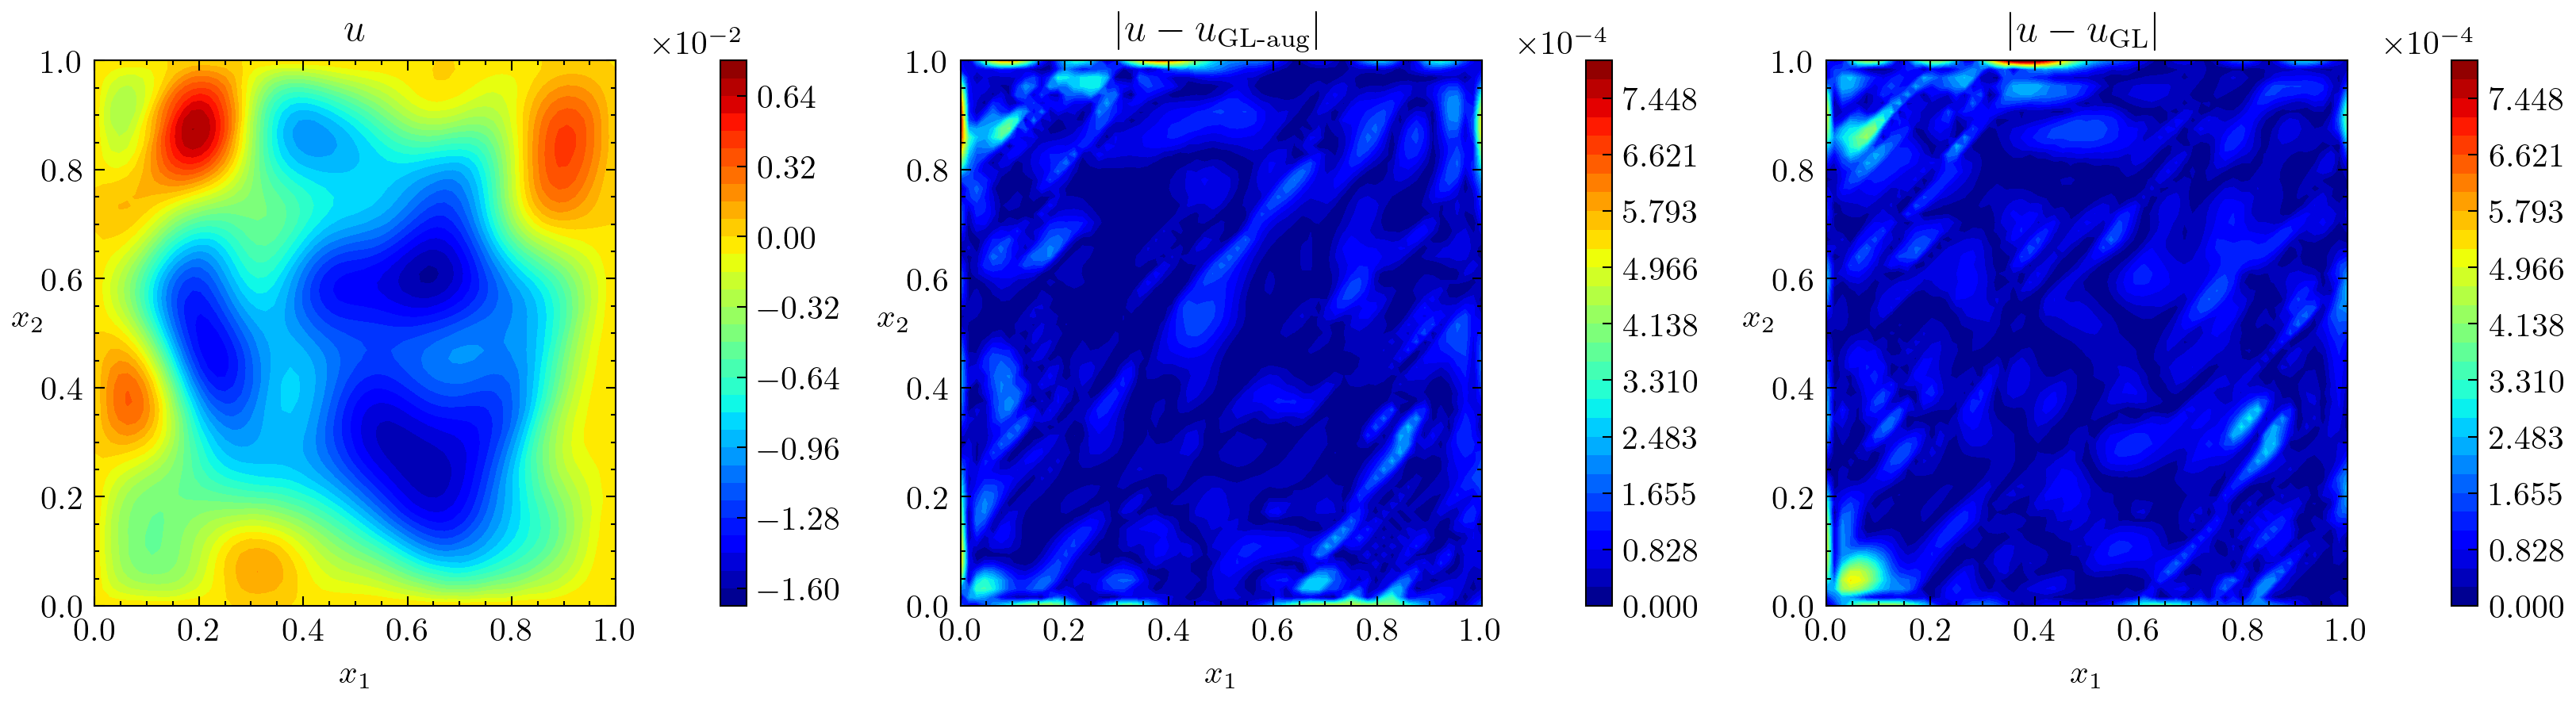

In [17]:
idx = 5 #np.argmin(err_diff)

cm = 1/2.54
f = plt.figure(figsize=(28*cm, 8*cm))

ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

im1 = ax1.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    U_test[:,idx].reshape(nh,nh), cmap='jet', levels=30)
ax1.title.set_text('$u$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$',rotation=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im1, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

vmin = 0 
vmax = 8e-4
err_levels = np.linspace(vmin,vmax,30)
im2 = ax2.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    np.abs(U_test[:,idx]-U_gnaug[:,idx]).reshape(nh,nh),
    cmap='jet', levels=err_levels)
ax2.title.set_text('$|u - u_{\\text{GL-aug}}|$')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$',rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im2, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

im3 = ax3.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    np.abs(U_test[:,idx]-U_gn[:,idx]).reshape(nh,nh),
    cmap='jet', levels=err_levels)
ax3.title.set_text('$|u - u_{\\text{GL}}|$')
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$x_2$',rotation=0)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im3, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

plt.tight_layout()

outnm = './{:}_usample.png'.format(task)
plt.savefig(outnm)

In [19]:
gnaug2_darcyrect_kernel.min(), gnaug2_darcyrect_kernel.max()

(-0.13545871, 0.01363842)

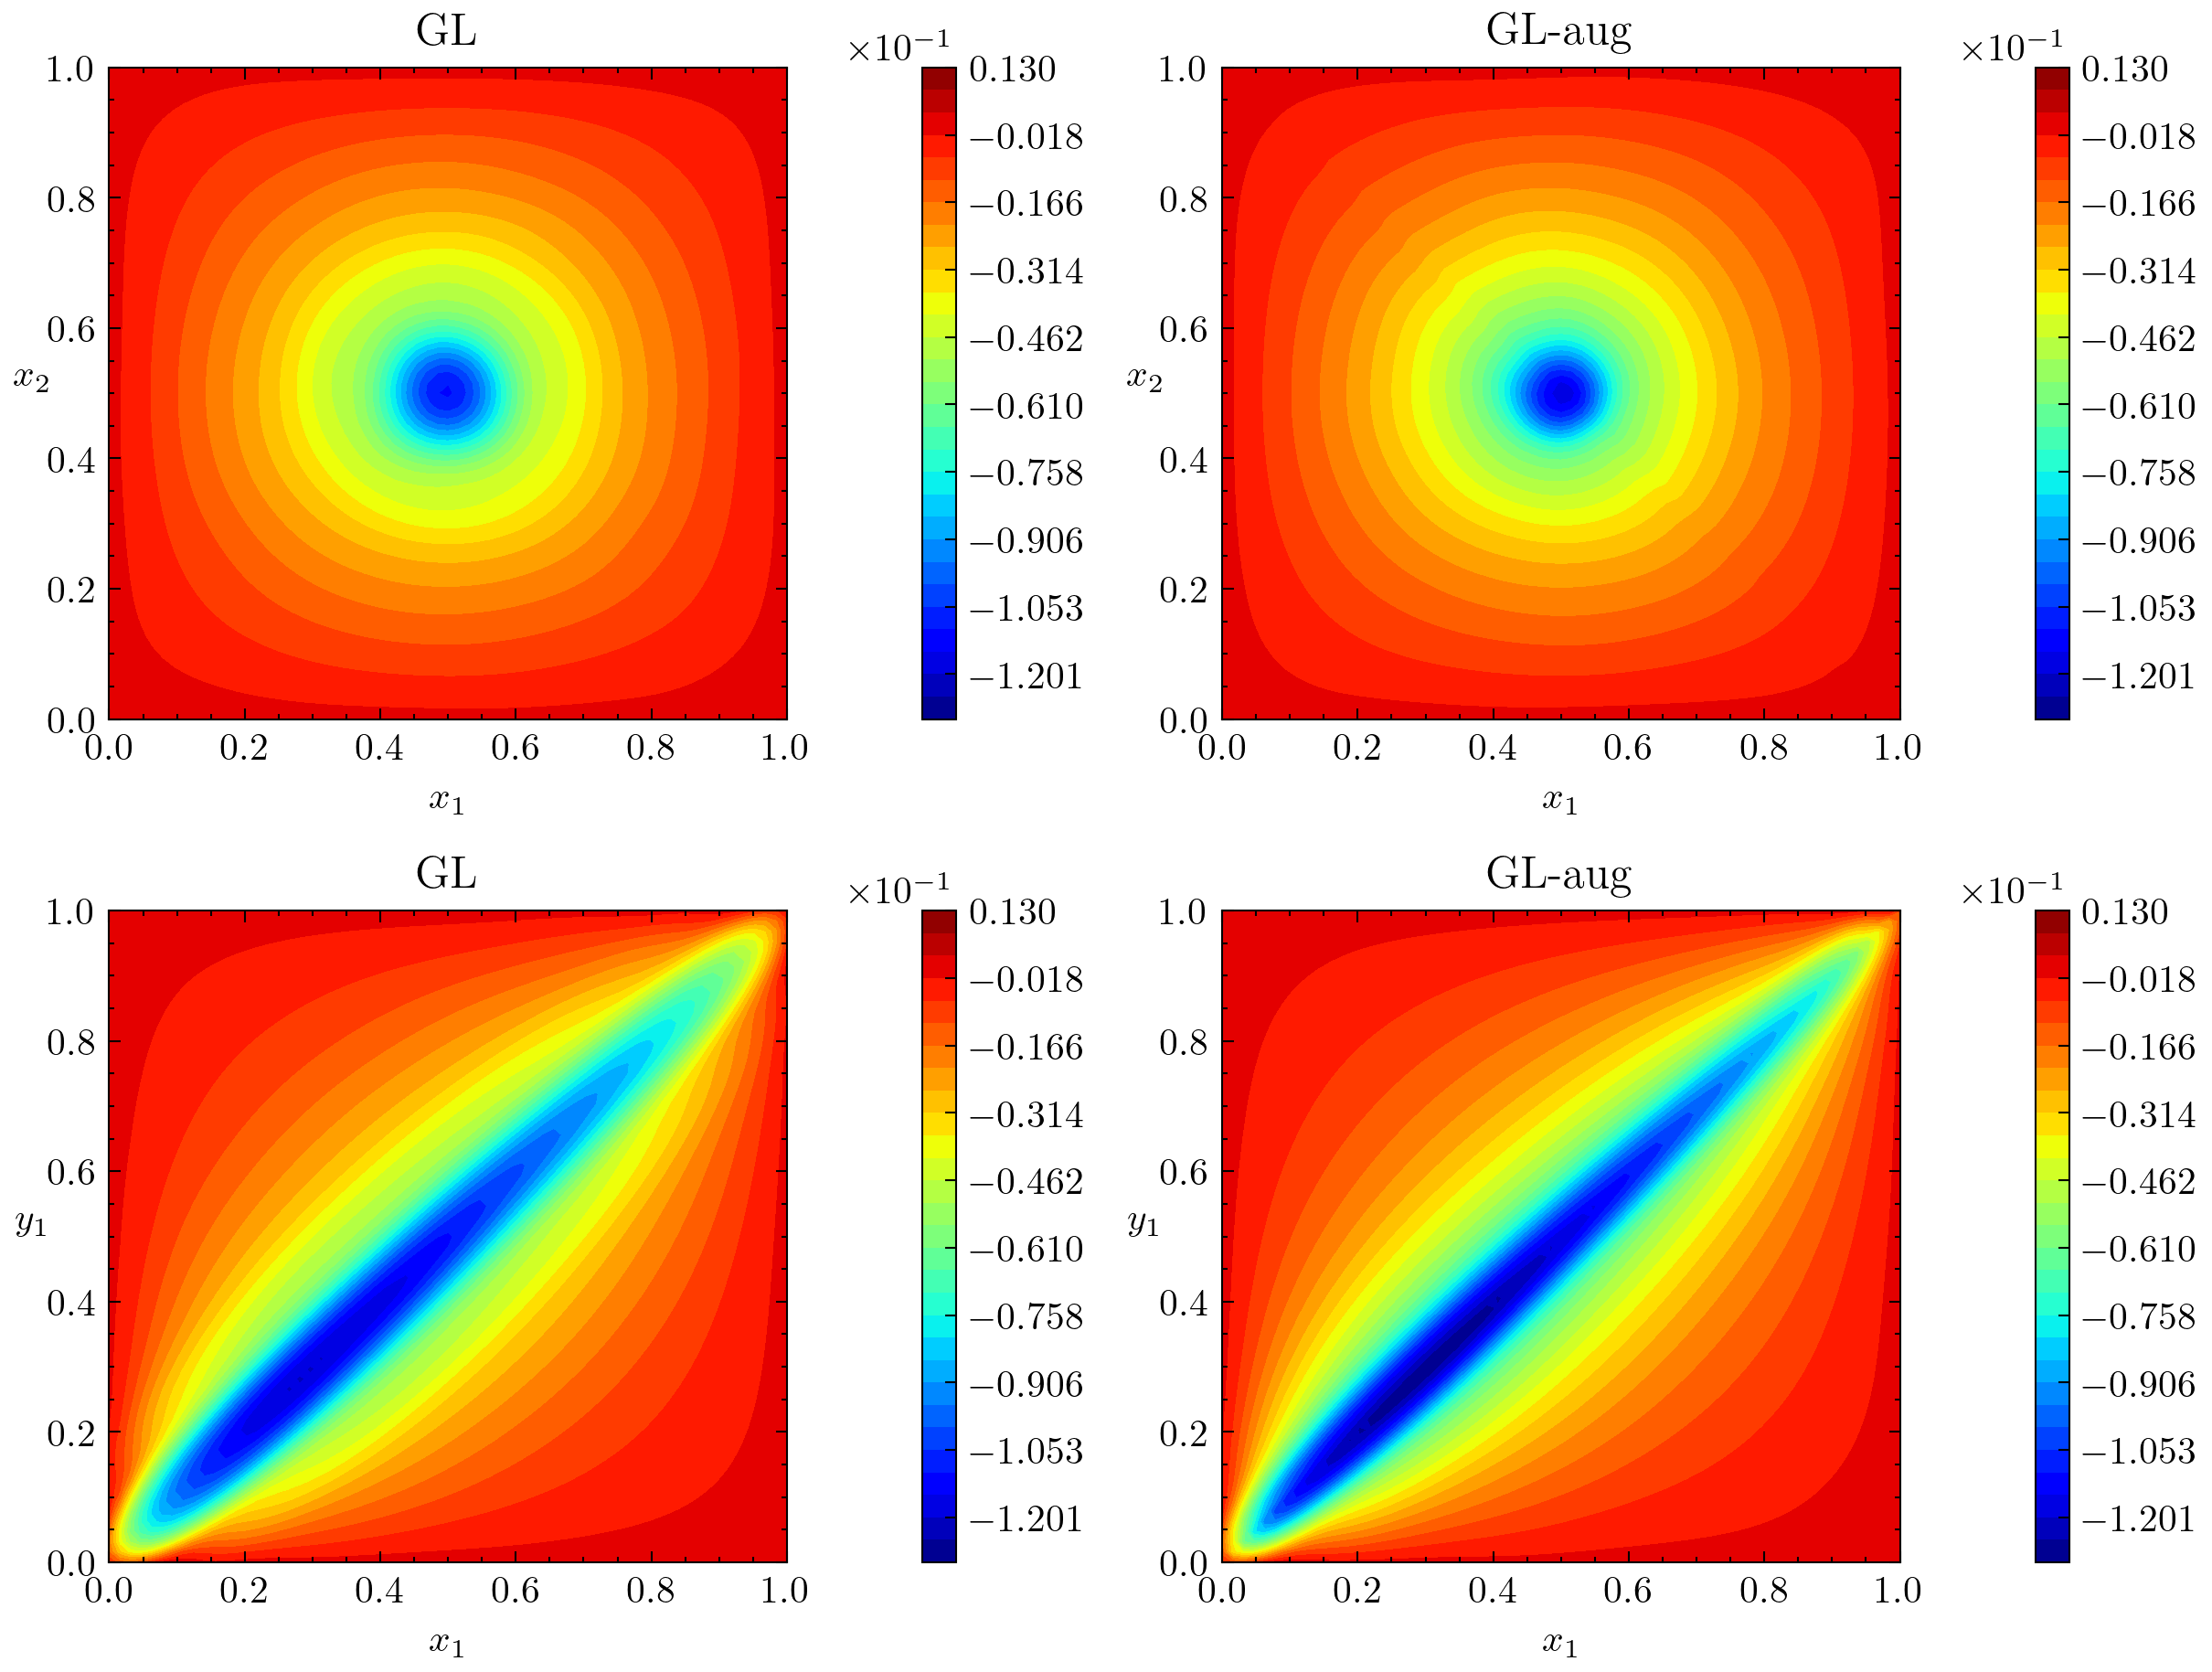

In [23]:
G_gn = gn_darcyrect_kernel.reshape(65,65,65,65)
G_gnaug = gnaug2_darcyrect_kernel.reshape(65,65,65,65)

cm = 1/2.54
f = plt.figure(figsize=(21*cm, 16*cm))

ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

levels = np.linspace(-0.13,0.013,30)

im1 = ax1.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    G_gn[:,:,32,32], cmap='jet', levels=levels)
ax1.title.set_text('$\\text{GL}$')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$',rotation=0)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im1, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

im2 = ax2.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    G_gnaug[:,:,32,32], cmap='jet', levels=levels)
ax2.title.set_text('$\\text{GL-aug}$')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$',rotation=0)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im2, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

im3 = ax3.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    G_gn[:,32,:,32], cmap='jet', levels=levels)
ax3.title.set_text('$\\text{GL}$')
ax3.set_xlabel('$x_1$')
ax3.set_ylabel('$y_1$',rotation=0)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im3, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

im4 = ax4.contourf(
    xhh[:,0].reshape(nh,nh), xhh[:,1].reshape(nh,nh), 
    G_gnaug[:,32,:,32], cmap='jet', levels=levels)
ax4.title.set_text('$\\text{GL-aug}$')
ax4.set_xlabel('$x_1$')
ax4.set_ylabel('$y_1$',rotation=0)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%')#, pad=0.2)
cbar = f.colorbar(im4, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

plt.tight_layout()

outnm = './{:}_kernels.png'.format(task)
plt.savefig(outnm)